# Feature visualization



This is the first part of a three-part series on neural style transfer. 


Notes:

REF on neural style transfer:

- https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf
- https://d2l.ai/chapter_computer-vision/neural-style.html

REF on feature vis:
- https://arxiv.org/abs/1412.0035
- https://arxiv.org/pdf/1512.02017.pdf
- https://distill.pub/2017/feature-visualization/
- https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html

REF on texture synthesis:
- https://arxiv.org/pdf/1606.01286.pdf

# Setup

In [140]:
# Imports
import torch
import torchvision
from torch import nn
import skimage
from skimage import transform
from skimage import io
# from im_func import show_image, timer
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from time import time
import contextlib

@contextlib.contextmanager
def timer(msg='timer'):
    tic = time()
    yield
    return print(f"{msg}: {time() - tic:.2f}")

# Get image

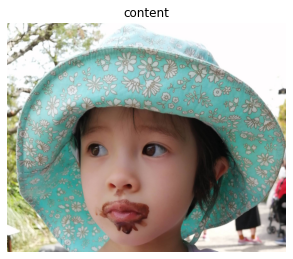

In [141]:
# content_im = skimage.io.imread("https://github.com/scijs/baboon-image/blob/master/baboon.png?raw=true")
content_im = skimage.io.imread("./Data/Cecile2.jpg")
fig, ax = plt.subplots(1,1,figsize=[5,5])
_ = plt.imshow(content_im); plt.title("content"); _ = plt.axis("off")

# Pre/Post processing

In [142]:
# im_shape = (150, 225)
# im_shape = (128,128)


# Get a pretrained model and choose a layer

In [143]:
pretrained_net = torchvision.models.vgg16(pretrained=True)#.features.to(device).eval()
display(pretrained_net.features)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

# Create a smaller model that contains only the needed layers

In [144]:


class SmallNet(nn.Module):
    def __init__(self, pretrained_net, last_layer):
        super(SmallNet,self).__init__()
        self.net= nn.Sequential(*([torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)] + 
                     [pretrained_net.features[i]
                            for i in range(last_layer + 1)])).to(device).eval()

    def forward(self, X, extract_layers):
        # Passes the image X through the pretrained network and 
        # returns a list containing the feature maps of layers specified in the list extract_layers
        detach = not(X.requires_grad) # We don't want to keep track of the gradients on the content image
        feature_maps = []
        for il in range(len(self.net)):
            X = self.net[il](X)
            if (il-1 in extract_layers): # note: il-1 because I added a normalization layer before the pretrained net in self.net
                if detach:
                    feature_maps.append(X.clone().detach())    
                else:
                    feature_maps.append(X.clone())
                    
        return feature_maps

# Define an image generator class

In [161]:
rgb_mean = torch.tensor([0.485, 0.456, 0.406]) # Fixed values for PyTorch pretrained models
rgb_std = torch.tensor([0.229, 0.224, 0.225])

class Image(nn.Module):
    def __init__(self, img=None, optimizable=True, img_shape=(64,64)):
        super(Image,self).__init__()
        
        self.img_shape = [32,32]
        
        if type(img)==type(None):
            self.img = torch.randn(self.img_shape + [3])
        else:
            self.img = img
                
        if optimizable == True:
            self.img = nn.Parameter(self.preprocess())
        else: 
            self.img = self.preprocess()
         
        self.jit_i = 0
        self.jit_j = 0
        self.angle = 0.0
    def preprocess(self):
        with torch.no_grad():
            transforms = torchvision.transforms.Compose([
                torchvision.transforms.ToPILImage(),
                torchvision.transforms.Resize(self.img_shape),
                torchvision.transforms.ToTensor(),
            ])
            return transforms(self.img).unsqueeze(0)
            

    def postprocess(self):
        with torch.no_grad():
            img = self.img.data[0].to(rgb_std.device).clone()
        return torchvision.transforms.ToPILImage()(img.permute(1, 2, 0).permute(2, 0, 1))
          
    def jittered_image(self):
        with torch.no_grad():
#             self.im.data = torchvision.transforms.functional.affine(self.im.data, angle=-self.angle, translate=(-self.jit_i/im_shape[1], -self.jit_j/im_shape[0]), scale=1., shear=[0.0,0.0])#,interpolation=torchvision.transforms.InterpolationMode.BILINEAR)
            jit_max = 2
            temp = np.random.standard_normal(2)*.5
            self.jit_i += temp[0]
            self.jit_j += temp[1]

            angle_max = 0.0
            self.angle += np.random.standard_normal(1)[0]*.3
            self.angle = np.clip(self.angle,-angle_max,angle_max)
            self.jit_i, self.jit_j = np.clip([self.jit_i, self.jit_j],-jit_max,jit_max)#.astype(int)
            print(self.angle, self.jit_i, self.jit_j, temp)
            return torchvision.transforms.functional.affine(self.img.data, angle=self.angle, translate=(self.jit_i/self.img_shape[1], self.jit_j/self.img_shape[0]), scale=1., shear=[0.0,0.0])#,interpolation=torchvision.transforms.InterpolationMode.BILINEAR)
            
        
    def forward(self, jitter=False):
        if jitter:
            return self.jittered_image()
        else:
            return self.img

# Loss and regularizer functions

In [162]:
class Losses(nn.Module):
    def __init__(self, img_ref, content_weight=1.0, tv_weight=0.0, clamp_weight=1.0, int_weight=0.0, alpha=6, beta=1.5):
        super(Losses,self).__init__()
        # img_ref is used to compute a reference total variation and reference intensity
        # tv_weight: weight of the total variation regularizer
        # int_weight: weight of the intensity regularizer
        # alpha: exponent for the intensity regularizer
        # beta: exponent for the total variation regularizer
        self.content_weight = content_weight
        self.tv_weight = tv_weight
        self.int_weight = int_weight
        self.clamp_weight = clamp_weight
        self.content_loss = 0.0
        self.tv_loss = 0.0
        self.int_loss = 0.0
        self.total_loss = 0.0
        
        self.alpha = alpha
        self.beta = beta
        
        self.B, self.V = self.get_regularizer_refs(img_ref)
        

    def get_content_loss(self, feature_map_gen, feature_map_content):
        # Mean squared error between generated and content image
        loss = 0
        for i in range(len(feature_map_content)):
            loss += torch.mean((feature_map_content[i]-feature_map_gen[i])**2)
        return loss

    def get_regularizer_refs(self, img):
        eps = 1e-10
        L2 = torch.sqrt(img[:,0,:,:]**2 + img[:,1,:,:]**2 + img[:,2,:,:]**2 + eps)
        B = L2.mean()

        d_dx = img[:,:,1:,:]-img[:,:,:-1,:]
        d_dy = img[:,:,:,1:]-img[:,:,:,:-1]
        L2 = torch.sqrt(d_dx[:,:,:,1:]**2 + d_dy[:,:,1:,:]**2 + eps)
        V = L2.mean()
        return B, V

    def get_int_loss(self, img):
        # Intensity loss
        H = img.shape[2]
        W = img.shape[3]
        eps = 1e-10
        L2 = torch.sqrt(img[:,0,:,:]**2 + img[:,1,:,:]**2 + img[:,2,:,:]**2 + eps)
        
        loss = 1./H/W/(self.B**self.alpha) * torch.sum(L2**self.alpha)
        
        return loss

    def get_clamp_loss(self, img):
        loss = torch.sum(img[img>1.0]**2) + torch.sum((1.0-img[img<0.0])**2)
        return loss

    def get_TV_loss(self, img):
        # Total variation loss
        H = img.shape[2]
        W = img.shape[3]
        C = img.shape[1]
        eps = 1e-10 # avoids accidentally taking the sqrt of a negative number because of rounding errors

        # # total variation
        d_dx = img[:,:,1:,:]-img[:,:,:-1,:]
        d_dy = img[:,:,:,1:]-img[:,:,:,:-1]
        # I ignore the first row or column of the image when computing the norm, in order to have vectors with matching sizes
        # Thus, d_dx and d_dy are not strictly colocated, but that should be a good enough approximation because neighbouring pixels are correlated
#         L2 = torch.sqrt(d_dx[:,:,:,1:]**2 + d_dy[:,:,1:,:]**2 + eps)
#         TV = torch.sum(L2**self.beta) # intensity regularizer

#         loss = 1./H/W/(self.V**self.beta) * TV
        loss = 1./H/W * (torch.sum(d_dx**2) + torch.sum(d_dy**2))
        return loss
    
    def forward(self,img,feature_map, feature_map_target):
        self.content_loss = self.get_content_loss(feature_map, feature_map_target)
        self.int_loss = self.get_int_loss(img)
        self.tv_loss = self.get_int_loss(img)
        self.clamp_loss = self.get_clamp_loss(img)
        
        self.total_loss = ( self.content_weight*self.content_loss 
                    + self.int_weight*self.int_loss 
                    + self.tv_weight*self.tv_loss 
                    + self.clamp_weight*self.clamp_loss )
        
        return self.total_loss

In [163]:
device = 'cpu'


img_content = Image(img=content_im, optimizable=False).to(device)
img_gen = Image(None, optimizable=True).to(device)

content_layer = [7]

net = SmallNet(pretrained_net, content_layer[-1])

loss_fn = Losses(img_content(), 
                 tv_weight=1.0, 
                 int_weight=0.1,
                 clamp_weight=10.0)

abs_loss_limit = 1e-3
rel_loss_limit = 1e-4

optimizer = torch.optim.LBFGS(img_gen.parameters())

# img_content().requires_grad
fm_content = net(img_content(), content_layer)

# Train

0.0 -2.0 0.1602450650170451 [-0.0356946   0.61898276]


KeyboardInterrupt: 

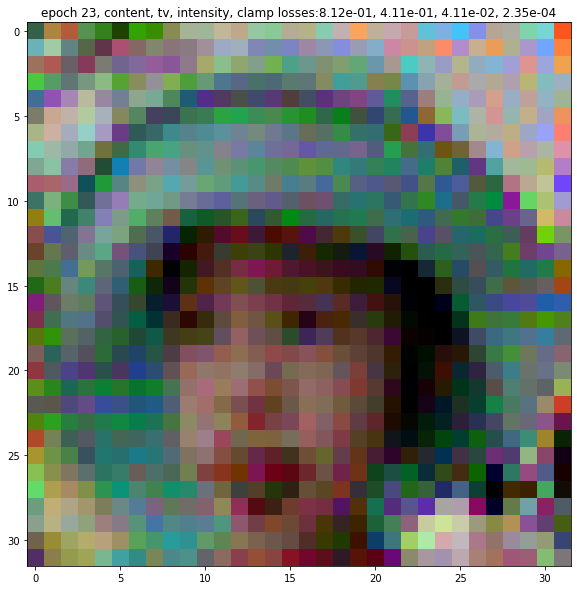

In [164]:
fig, ax = plt.subplots(1,1,figsize=[10,10])


def closure():
    optimizer.zero_grad()
    fm_gen = net(img_gen(), content_layer)
    loss = loss_fn(img_gen(), fm_gen, fm_content)
    loss.backward()
    return loss

last_loss = 1e10
frame = 0
for i in range(400):    
    fm_content = net(img_content(jitter=True), content_layer)
    optimizer.step(closure)
    
    if i%1==0:
        with torch.no_grad():
#             print(f"epoch {i:02d}, content, tv, intensity losses: {content_weight*content_loss:.2e}, {tv_weight*tv_loss:.2e}, {int_weight*int_loss:.2e}")
            plt.clf()
            plt.imshow(img_gen.postprocess())
            plt.title(f"epoch {i:02}, content, tv, intensity, clamp losses:" + 
                      f"{loss_fn.content_weight*loss_fn.content_loss:.2e}, " + 
                      f"{loss_fn.tv_weight*loss_fn.tv_loss:.2e}, " +
                      f"{loss_fn.int_weight*loss_fn.int_loss:.2e}, " + 
                      f"{loss_fn.clamp_weight*loss_fn.clamp_loss:.2e}")
            display(fig)
            clear_output(wait = True)
            
            plt.savefig(f"./Output/Frame{frame:05d}")
            frame += 1

            if loss_fn.total_loss<abs_loss_limit:
                clear_output(wait = True)
                print(f'success: absolute loss limit ({abs_loss_limit:.1e}) reached')
                break
            if torch.abs(last_loss-loss_fn.total_loss)<rel_loss_limit:
                clear_output(wait = True)
                print(f'stopped because relative loss limit ({rel_loss_limit:.1e})  was reached')
                break
                
            last_loss = loss_fn.total_loss


tensor(-0.3154, grad_fn=<MinBackward1>)

In [ ]:
img_content().requires_grad